In [1]:
# Imports
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")

# Variational Autoencoder

The variational autoencoder (VAE) was described in its current form in [Kingma 2013](https://arxiv.org/abs/1312.6114). The model consists of an encoder/inference network $q_{\phi}(z|x)$ and a decoder/generative network $p_{\theta}(x|z)$. The main idea is that it is possible to both reconstruct and generate samples from from some input distribution by learning a variational distribution over the latent variable $z$.

<img src="../images/vae.png" width="300px"/>

The VAE therefore has a bottleneck structure, where the input $x$ is encoded into a latent variable $z$. New data can then be generated by feeding a latent code into the generator network - $\widehat{x} \sim p_{\theta}(z|x)$. The diagram above shows the generative model (right) and how the latent variable $z$ is inferred from $x$ (left).

Below we will instantiate a new variational autoencoder with this bottleneck structure consisting of a 2-layer encoder network turning an input MNIST image into a latent code: $784 \to 256 \to 128 \to 32$. We also have a decoder that performs the operation in reverse: $32 \to 128 \to 256 \to 784$.

In [2]:
from models import VariationalAutoencoder
from layers import GaussianSample
model = VariationalAutoencoder([64 * 64 * 3, 300, [300]], conv=True).cuda()
model

../../semi-supervised/models/vae.py:260: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


VariationalAutoencoder(
  (pre_encoder): ConvPreEncoder(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  )
  (post_decoder): ConvPostDecoder(
    (conv_layers): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): Sigmoid()
    )
  )
  (encoder): Encoder(
    (first_dense): Module

Notice how the middle most layer consists of a `GaussianSample` layer, in which we turn the input digit into the parameters of a Normal distribution with parameters $\mu$ and $\sigma$. This allows us to use the *reparametrization trick* to sample from this distribution to introduce stochasticity into the network.

In [3]:
from torch.autograd import Variable

gaussian = GaussianSample(10, 1)
z, mu, log_var = gaussian(Variable(torch.ones(1, 10)))

print(f"sample {float(z.data):.2f} drawn from N({float(mu.data):.2f}, {float(log_var.exp().data):.2f})")

sample 0.42 drawn from N(-1.38, 1.20)


In [4]:
from datautils import get_celeba, get_mnist, get_svhn

_, train, validation, std = get_celeba(location="./", batch_size=256)
# _, train, validation, mnist_mean, mnist_std = get_mnist(location="./", batch_size=100, labels_per_class=10, preprocess=False)


# We use this custom BCE function until PyTorch implements reduce=False
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

def mse(r, x):
    x = x.view(x.shape[0], -1)
    r = r.view(r.shape[0], -1)
    return torch.sum(torch.pow(x - r, 2), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

Epoch: 0	L: 234.47


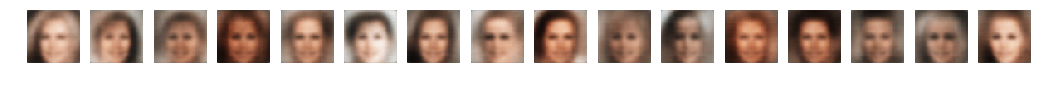

Epoch: 1	L: 221.54
Epoch: 2	L: 212.78
Epoch: 3	L: 206.69
Epoch: 4	L: 202.00
Epoch: 5	L: 198.28
Epoch: 6	L: 195.22
Epoch: 7	L: 192.83
Epoch: 8	L: 190.80
Epoch: 9	L: 188.80
Epoch: 10	L: 187.06
Epoch: 11	L: 185.67
Epoch: 12	L: 184.44
Epoch: 13	L: 183.38
Epoch: 14	L: 182.35
Epoch: 15	L: 181.43
Epoch: 16	L: 180.56
Epoch: 17	L: 179.81
Epoch: 18	L: 179.18
Epoch: 19	L: 178.48
Epoch: 20	L: 177.92
Epoch: 21	L: 177.35
Epoch: 22	L: 176.90
Epoch: 23	L: 176.43
Epoch: 24	L: 175.98
Epoch: 25	L: 175.49
Epoch: 26	L: 175.08
Epoch: 27	L: 174.67
Epoch: 28	L: 174.24
Epoch: 29	L: 173.89
Epoch: 30	L: 173.53
Epoch: 31	L: 173.22
Epoch: 32	L: 172.92
Epoch: 33	L: 172.68
Epoch: 34	L: 172.40
Epoch: 35	L: 172.13
Epoch: 36	L: 171.88
Epoch: 37	L: 171.62
Epoch: 38	L: 171.35
Epoch: 39	L: 171.12
Epoch: 40	L: 170.90
Epoch: 41	L: 170.70
Epoch: 42	L: 170.48
Epoch: 43	L: 170.28
Epoch: 44	L: 170.10
Epoch: 45	L: 169.94
Epoch: 46	L: 169.74
Epoch: 47	L: 169.60
Epoch: 48	L: 169.43
Epoch: 49	L: 169.30
Epoch: 50	L: 169.17


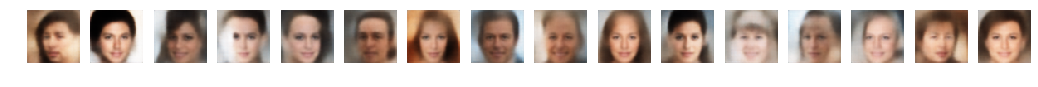

Epoch: 51	L: 169.05
Epoch: 52	L: 168.91
Epoch: 53	L: 168.79
Epoch: 54	L: 168.70
Epoch: 55	L: 168.55
Epoch: 56	L: 168.38
Epoch: 57	L: 168.34
Epoch: 58	L: 168.25
Epoch: 59	L: 168.07
Epoch: 60	L: 167.99
Epoch: 61	L: 167.88
Epoch: 62	L: 167.80
Epoch: 63	L: 167.69
Epoch: 64	L: 167.58
Epoch: 65	L: 167.50
Epoch: 66	L: 167.35
Epoch: 67	L: 167.26
Epoch: 68	L: 167.19
Epoch: 69	L: 167.12
Epoch: 70	L: 167.05
Epoch: 71	L: 166.93
Epoch: 72	L: 166.85
Epoch: 73	L: 166.76
Epoch: 74	L: 166.70
Epoch: 75	L: 166.62
Epoch: 76	L: 166.54
Epoch: 77	L: 166.47
Epoch: 78	L: 166.41
Epoch: 79	L: 166.31
Epoch: 80	L: 166.25
Epoch: 81	L: 166.17
Epoch: 82	L: 166.13
Epoch: 83	L: 166.07
Epoch: 84	L: 165.97
Epoch: 85	L: 165.93
Epoch: 86	L: 165.90
Epoch: 87	L: 165.77
Epoch: 88	L: 165.77
Epoch: 89	L: 165.66
Epoch: 90	L: 165.61
Epoch: 91	L: 165.57
Epoch: 92	L: 165.54
Epoch: 93	L: 165.44
Epoch: 94	L: 165.40
Epoch: 95	L: 165.39
Epoch: 96	L: 165.28
Epoch: 97	L: 165.27
Epoch: 98	L: 165.23
Epoch: 99	L: 165.15
Epoch: 100	L: 165.10

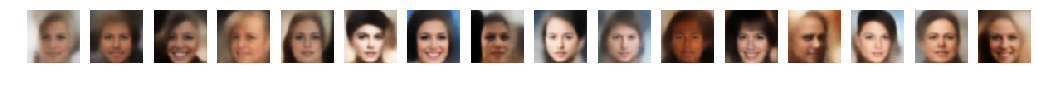

Epoch: 101	L: 165.02
Epoch: 102	L: 165.00
Epoch: 103	L: 164.91
Epoch: 104	L: 164.87
Epoch: 105	L: 164.83
Epoch: 106	L: 164.82
Epoch: 107	L: 164.73
Epoch: 108	L: 164.68
Epoch: 109	L: 164.61
Epoch: 110	L: 164.54
Epoch: 111	L: 164.59
Epoch: 112	L: 164.42
Epoch: 113	L: 164.41
Epoch: 114	L: 164.34
Epoch: 115	L: 164.33
Epoch: 116	L: 164.29
Epoch: 117	L: 164.26
Epoch: 118	L: 164.19
Epoch: 119	L: 164.20
Epoch: 120	L: 164.13
Epoch: 121	L: 164.09
Epoch: 122	L: 164.06
Epoch: 123	L: 164.02
Epoch: 124	L: 163.99
Epoch: 125	L: 163.92
Epoch: 126	L: 163.93
Epoch: 127	L: 163.86
Epoch: 128	L: 163.82
Epoch: 129	L: 163.83
Epoch: 130	L: 163.74
Epoch: 131	L: 163.77
Epoch: 132	L: 163.70
Epoch: 133	L: 163.64
Epoch: 134	L: 163.63
Epoch: 135	L: 163.61
Epoch: 136	L: 163.57
Epoch: 137	L: 163.51
Epoch: 138	L: 163.49
Epoch: 139	L: 163.47
Epoch: 140	L: 163.44
Epoch: 141	L: 163.41
Epoch: 142	L: 163.40
Epoch: 143	L: 163.35
Epoch: 144	L: 163.31
Epoch: 145	L: 163.30
Epoch: 146	L: 163.28
Epoch: 147	L: 163.21
Epoch: 148	L:

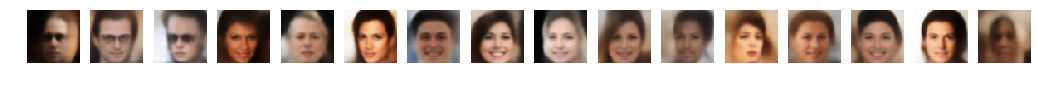

Epoch: 151	L: 163.13
Epoch: 152	L: 163.07
Epoch: 153	L: 163.03
Epoch: 154	L: 162.97
Epoch: 155	L: 163.02
Epoch: 156	L: 162.94
Epoch: 157	L: 162.90
Epoch: 158	L: 162.87
Epoch: 159	L: 162.84
Epoch: 160	L: 162.81
Epoch: 161	L: 162.79
Epoch: 162	L: 162.74
Epoch: 163	L: 162.74
Epoch: 164	L: 162.68
Epoch: 165	L: 162.70
Epoch: 166	L: 162.66
Epoch: 167	L: 162.63
Epoch: 168	L: 162.60
Epoch: 169	L: 162.59
Epoch: 170	L: 162.57
Epoch: 171	L: 162.52
Epoch: 172	L: 162.49
Epoch: 173	L: 162.50
Epoch: 174	L: 162.45
Epoch: 175	L: 162.44
Epoch: 176	L: 162.41
Epoch: 177	L: 162.39
Epoch: 178	L: 162.35
Epoch: 179	L: 162.35
Epoch: 180	L: 162.34
Epoch: 181	L: 162.34
Epoch: 182	L: 162.29
Epoch: 183	L: 162.25
Epoch: 184	L: 162.22
Epoch: 185	L: 162.17
Epoch: 186	L: 162.17
Epoch: 187	L: 162.16
Epoch: 188	L: 162.16
Epoch: 189	L: 162.14
Epoch: 190	L: 162.06
Epoch: 191	L: 162.06
Epoch: 192	L: 162.01
Epoch: 193	L: 161.99
Epoch: 194	L: 161.95
Epoch: 195	L: 161.94
Epoch: 196	L: 161.94
Epoch: 197	L: 161.93
Epoch: 198	L:

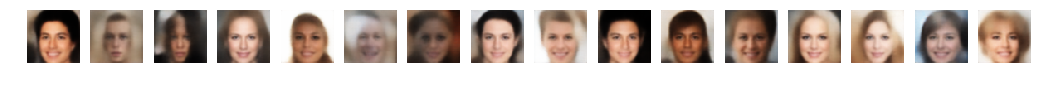

Epoch: 201	L: 161.84
Epoch: 202	L: 161.82
Epoch: 203	L: 161.79
Epoch: 204	L: 161.76
Epoch: 205	L: 161.87
Epoch: 206	L: 161.85
Epoch: 207	L: 161.71
Epoch: 208	L: 161.70
Epoch: 209	L: 161.63
Epoch: 210	L: 161.65
Epoch: 211	L: 161.63
Epoch: 212	L: 161.60
Epoch: 213	L: 161.58
Epoch: 214	L: 161.56
Epoch: 215	L: 161.55
Epoch: 216	L: 161.56
Epoch: 217	L: 161.50
Epoch: 218	L: 161.47
Epoch: 219	L: 161.49
Epoch: 220	L: 161.47
Epoch: 221	L: 161.42
Epoch: 222	L: 161.42
Epoch: 223	L: 161.39
Epoch: 224	L: 161.34
Epoch: 225	L: 161.37
Epoch: 226	L: 161.33
Epoch: 227	L: 161.29
Epoch: 228	L: 161.31
Epoch: 229	L: 161.29
Epoch: 230	L: 161.25
Epoch: 231	L: 161.23
Epoch: 232	L: 161.22
Epoch: 233	L: 161.19
Epoch: 234	L: 161.18
Epoch: 235	L: 161.17
Epoch: 236	L: 161.16
Epoch: 237	L: 161.15
Epoch: 238	L: 161.15
Epoch: 239	L: 161.11
Epoch: 240	L: 161.10
Epoch: 241	L: 161.08
Epoch: 242	L: 161.09
Epoch: 243	L: 161.06
Epoch: 244	L: 161.02
Epoch: 245	L: 161.02
Epoch: 246	L: 161.03
Epoch: 247	L: 161.00
Epoch: 248	L:

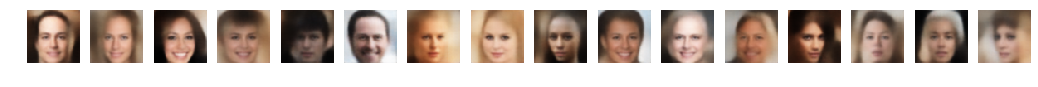

Epoch: 251	L: 160.92
Epoch: 252	L: 160.89
Epoch: 253	L: 160.91
Epoch: 254	L: 160.86
Epoch: 255	L: 160.87
Epoch: 256	L: 160.87
Epoch: 257	L: 160.86
Epoch: 258	L: 160.84
Epoch: 259	L: 160.78
Epoch: 260	L: 160.81
Epoch: 261	L: 160.77
Epoch: 262	L: 160.77
Epoch: 263	L: 160.78
Epoch: 264	L: 160.73
Epoch: 265	L: 160.75
Epoch: 266	L: 160.71
Epoch: 267	L: 160.69
Epoch: 268	L: 160.67
Epoch: 269	L: 160.67
Epoch: 270	L: 160.67
Epoch: 271	L: 160.67
Epoch: 272	L: 160.63
Epoch: 273	L: 160.61
Epoch: 274	L: 160.63
Epoch: 275	L: 160.60
Epoch: 276	L: 160.59
Epoch: 277	L: 160.59
Epoch: 278	L: 160.57
Epoch: 279	L: 160.56
Epoch: 280	L: 160.56
Epoch: 281	L: 160.51
Epoch: 282	L: 160.49
Epoch: 283	L: 160.50
Epoch: 284	L: 160.48
Epoch: 285	L: 160.47
Epoch: 286	L: 160.45
Epoch: 287	L: 160.45
Epoch: 288	L: 160.45
Epoch: 289	L: 160.45
Epoch: 290	L: 160.42
Epoch: 291	L: 160.38
Epoch: 292	L: 160.37
Epoch: 293	L: 160.39
Epoch: 294	L: 160.33
Epoch: 295	L: 160.34
Epoch: 296	L: 160.33
Epoch: 297	L: 160.30
Epoch: 298	L:

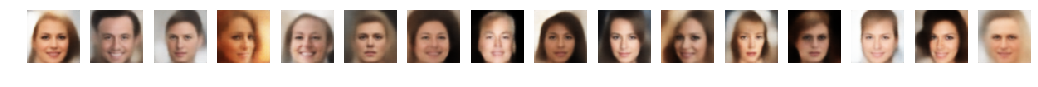

In [6]:
from tqdm import tnrange

torch.multiprocessing.set_sharing_strategy('file_system')

for epoch in tnrange(301):
    model.train()
    total_loss = 0
    for (u, _) in train:
        u = Variable(u)

        if cuda: u = u.cuda()

        reconstruction = model(u)
        
        # print(reconstruction.shape)
        likelihood = -mse(reconstruction, u)
        elbo = likelihood - model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data.item()

    m = len(train)

    if epoch % 1 == 0:
        print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}")
    
    if epoch % 50 == 0:
        model.eval()
        x_mu = model.sample(Variable(torch.randn(16, 300)).cuda())
        f, axarr = plt.subplots(1, 16, figsize=(18, 12))
        # samples = x_mu.data.cpu().numpy().reshape(-1, 28, 28)
        
        # mnist_means = np.tile(mnist_mean.reshape((1, -1)), (len(samples), 1))
        # mnist_means[:, mnist_std > 0.1] = samples
        # samples = mnist_means.reshape(-1, 28, 28)

        samples = x_mu.data.view(-1, 3, 64, 64).cpu().numpy().transpose(0, 2, 3, 1)
        for i, ax in enumerate(axarr.flat):
            ax.imshow(samples[i], cmap="gray")
            ax.axis("off")
        plt.show()

## Sampling from the generative model

Now that we have trained the network, we can begin to sample from it. We simply give it some random noise distributed according to the prior $p(z) = \mathcal{N}(0, I)$ and send it through the decoder. This process generates a slew of samples that look like they come from the original distribution $p(x)$.

In [7]:
# torch.save(model.state_dict(), "vae_celeba.ckpt")